# Probability & Statistics applications in Sales Management Analysis 

A collection of data driven problem solving cases applied to assist sales management decisions, addressed in a data science perspective with applied mathematical, statistical and probability skills.

### Table of Contents
- 1. Salesperson Time
- 2. Net Gain from Salesperson activity
- 3. Fuel Retailer Company Sales Achievements
- ??? ?? 

***

## 1. Salesperson Time

An operator works at a call center as a phone salesperson. The call center records the number of contracts closed on a hourly basis and the time spent on the phone. 

**Based on the data available the sales director requests an elaboration of the expected time the operator spends on the phone every hour, and the probability for the operator to close more than 10 contracts every hour.**

An excel report file is available for the last month for that operator.

I'll use Python with basic libraries and KernelDensity from Scikit-learn, this is because, in order to solve this problem, **we'll need some machine learning power.**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.neighbors import KernelDensity

And now we can import the excel file:

In [3]:
operator = pd.read_excel('operator_sales.xlsx',
#sheetname=0,
header=0,
index_col=False,
keep_default_na=True
)
#display first rows
operator.head()

,hrID,contracts,time
0,1001,7,00:42:50.808000
1,1002,0,00:05:40.540000
2,1003,0,00:05:18.919000
3,1004,1,00:16:19.999000
4,1005,1,00:13:04.864000


`time` feauture is not in the correct format by default so we need to apply some changes in order to make calculations, and maybe grouping it by contracts. I'll create a **function** with parameters: ***dataset, grouping column, and the time column***. And then generate some statistics for time data.

In [4]:
def stats_time(data,group_by,time_col_name):
    
    #change time format
    data[time_col_name] = pd.to_datetime(data[time_col_name], format='%H:%M:%S.%f')
    
    #create a global variables to access later on
    global df_stats_time
    global groups
    
    #group by contracts
    group = data.groupby(group_by)
    
    #prepare dataframe with average times per contract in total minutes, also min and max times
    dat = pd.DataFrame(([i, 
                        int(round(float(data[time_col_name][group.groups.get(i)].mean().strftime('%M.%S')), 0)) % 60,
                        data[time_col_name][group.groups.get(i)].min().strftime('%M:%S'),
                        data[time_col_name][group.groups.get(i)].max().strftime('%M:%S')] 
                      for i in range(0,len(group))),
                      columns=[group_by,'AverageTimeMinutes',"MinimumTime","MaximumTime"])
    
    #assign dataframe to the global variables
    df_stats_time = dat
    groups = group
    #return printed results
    print('Statistics:\n',dat.to_string(index=False),'\n')
    print("Use 'df_stats_time' as data frame for this table \n")
    print("Use 'groups' to query the grouped data\n")

Now I can use the function:

In [5]:
stats_time(operator,'contracts','time')

Statistics:
  contracts  AverageTimeMinutes MinimumTime MaximumTime
         0                   7       01:50       16:12
         1                  12       04:21       21:04
         2                  15       08:53       26:29
         3                  21       17:17       29:16
         4                  24       15:52       32:12
         5                  31       22:47       39:38
         6                  36       31:22       42:09
         7                  32       26:51       42:50
         8                  41       34:03       49:39
         9                  49       44:35       51:21
        10                  45       42:58       49:37 

Use 'df_stats_time' as data frame for this table 

Use 'groups' to query the grouped data



I've added some global variables in the function so we can do further calculations with it. For example I can compute now the average time of a call to close a contract:

In [6]:
#using the global variable of the above function
ls = []
for index, row in df_stats_time[1:].iterrows(): #[1:] to skip the first row with 0 contracts
         ls.append(row['AverageTimeMinutes']/row['contracts'])
print('The average time of a call to close one contract is',int(round(np.median(ls),0)),'minutes')

The average time of a call to close one contract is 6 minutes


I can also query by the number of contracts in an hour:

In [7]:
#query a group using the global variable of the function above
operator.iloc[groups.groups.get(10)].head()

,hrID,contracts,time
49,1050,10,1900-01-01 00:42:58.376
120,1121,10,1900-01-01 00:43:35.133
145,1146,10,1900-01-01 00:49:37.294


Now we can see that it is not so easy for this operator closing more than 10 contracts in one hour. The average time is 45min for 10 contracts with a minimum of 43min and maximum of 49min. **The operator is only left with 15min of time and with an average of 6 minutes to close a contract (15/6=2.5 we can approximate to 3 contracts) this gives us a maximum of 10+3=13 contracts per hour.** 

This sounds quite strange because 13x6 is more than 60 minutes but we have to consider that the operator has an ability to close 10 contracts in 45 minutes and that is 4.5 minutes per contract, but as also made a 12 minutes call per contract in the data set. So we have to consider the average we have calculated above in order to have a realistic number of maximum contracts he could close in one hour, and if we take 60 minutes and divide it by 4.5 the result is 13.3 contracts that is 13 as expected. So we know our average is a good estimation.

Let's now view statistics for the contracts:

In [8]:
operator.contracts.describe()

count    190.000000
mean       2.615789
std        2.685403
min        0.000000
25%        1.000000
50%        1.000000
75%        4.000000
max       10.000000
Name: contracts, dtype: float64

We have 190 hour records, and as we can see, this particular operator has closed a maximum of 10 contracts per hour in the last month. So it is difficult to evaluate if he can make more. 

**How can we compute the probability that he closes more than 10 contrats per hour?** Normally we would have to say that we cannot answer to this question with this data available, but we can make some estimations using **KDE (Kernel Density Estimation)**. KDE is a non-parametric way to estimate the probability density function of a random variable. It can help us by emulating the distribution even where we do not have the data, this by learning from the exixting one, and for example, it can then be used to predict the density across other ranges of unknown data.

I'll start by plotting the histogram of the data we have, and compute the kernel density estimation of that data.

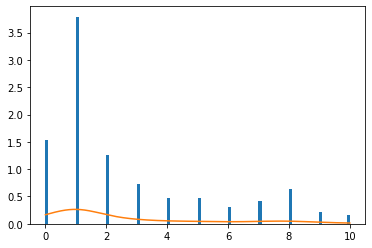

In [11]:
#initialize data for computing
data = operator.contracts.to_numpy().reshape(-1, 1)

# linear space of numbers from min to max with n numbers
x = np.linspace(min(operator.contracts), 
                max(operator.contracts), 
                1000)[:, np.newaxis]

# Plot the data using a normalized histogram
plt.hist(operator.contracts, 100, density=True)

# Do kernel density estimation
kd = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(data)

# Plot the estimated density with the linear space of numbers
kd_vals = np.exp(kd.score_samples(x))
plt.plot(x, kd_vals)

# Show the plots
plt.show()

I can compute the probability of a range of contracts the operator can close in an hour time:

In [12]:
# Get probability for range of values
start = 0  # Start of the range
end = 10    # End of the range
N = 1000    # Number of evaluation points 
step = (end - start) / (N - 1)  # Step size
x = np.linspace(start, end, N)[:, np.newaxis]  # Generate values in the range
kd_vals = np.exp(kd.score_samples(x))  # Get PDF values for each x
probability = np.sum(kd_vals * step)  # Approximate the integral of the PDF
print('The probability to have closed contracts range from',start,'to',end,'every hour is:',round(probability,5))

The probability to have closed contracts range from 0 to 10 every hour is: 0.87947


We could actually say that the probability to have more than 10 contracts is 1 minus that result, but we have to consider that the bandwidth (smoothing parameter) of KDE can vary a lot these results. Low bandwidth values will better fit the data we have and this will return less probability to have more than 10 contracts per hour, viceversa an higher bandwidth will smooth the estimation expanding the probability to have more than 10 contracts per hour.

So I'll create a function that replicates kde with different bandwidth values and then chooses the one most probable.

In [13]:
def replicate_kde(data,start, end, N, min_bandwith, max_bandwith, sample_bandwith):
    #import numpy as np
    ls = []
    x = np.linspace(start, end, N)[:, np.newaxis]
    step = (end - start) / (N - 1) 
    for i in np.linspace(min_bandwith, max_bandwith, sample_bandwith):
        kdes = KernelDensity(kernel='gaussian', bandwidth=i).fit(data)
        kd_vals = np.exp(kdes.score_samples(x))
        probability = np.sum(kd_vals * step)
        ls.append(round(probability,5))
    print('The minimum probability of closed contracts in range from',start,'to',end,'every hour is:', min(ls))
    print('The maximum probability of closed contracts in range from',start,'to',end,'every hour is:', max(ls))
    print('The median is:')
    return round(scipy.median(ls),5)

I will now apply the function with a parameter range from 11 to 13 has calculated before (the maximum number of contracts this operator can closein one hour):

In [14]:
replicate_kde(data,11,13,1000,0.3, 3,100)

The minimum probability of closed contracts in range from 11 to 13 every hour is: 1e-05
The maximum probability of closed contracts in range from 11 to 13 every hour is: 0.0197
The median is:


0.00844

I've computed the median of the results because if the data is skewed the average will tend to be less accurate. With the median we know that the higher density of the data will be close to this value.

So we have a minimum probability of around zero and a maximum of 0.0197, and a median of 0.00844, that is 8 times every 1,000 hours or **a probability of approx 0.8% that the operator closes 11 or more contracts in 1 hour** with a maximum of 13 closed contracts.

Now, to compute the expected time the operator spends on the phone every hour we have to consider the data we have for the last month. So we'll compute the probability for each number of contracts closed in an hour and then calculte EVs.

I'll use `Counter()` from `collections` to make the proces easier inside a function that returns the probabilty for a given number of contracts in our data:

In [15]:
def probability(data_column,value):
    from collections import Counter
    c = Counter(data_column)
    # returns the probability of a given number a
    return float(c[value]) / len(data_column)

Test the function:

In [16]:
probability(operator.contracts,10)

0.015789473684210527

The resulted probability for 10 contracts in 1 hour is approx = 1.6%

Now we can build the probability table:

In [17]:
df_prob_operator = df_stats_time.loc[:,['contracts','AverageTimeMinutes']]
df_prob_operator['Probability'] = [probability(operator.contracts,x) for x in df_prob_operator['contracts']]

In [21]:
df_prob_operator.to_csv('prob_operator_distribution.csv', header=True, index=False)
df_prob_operator

,contracts,AverageTimeMinutes,Probability
0,0,7,0.152632
1,1,12,0.378947
2,2,15,0.126316
3,3,21,0.073684
4,4,24,0.047368
5,5,31,0.047368
6,6,36,0.031579
7,7,32,0.042105
8,8,41,0.063158
9,9,49,0.021053


I'll plot the probabilities even if we have already viewed the histogram with frequency for the contracts:

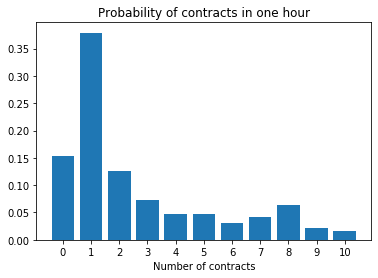

In [16]:
#plotting probabilities
plt.bar(df_prob_operator.contracts, df_prob_operator.Probability)
plt.xticks(df_prob_operator.contracts, ('0','1','2','3','4','5','6','7','8','9','10'))
plt.title('Probability of contracts in one hour')
plt.xlabel('Number of contracts')
plt.show()

To compute now the expected time the operator spends on the phone each hour, we can do it by:
    
$$ \sum_i\;E(Ct_i) $$

We can sum all the expected contracts times $E(Ct)=Ct*P(Ct)$

In [17]:
#apply calculations
df_prob_operator['Et'] = [x*i for x,i in zip(df_prob_operator.AverageTimeMinutes, df_prob_operator.Probability)]

In [18]:
#print resuts and table with EVs
print(df_prob_operator)
print('\nThe Expected Time for this operator is:',
      round(sum(df_prob_operator.Et),2),
      'minutes spent on the phone every hour')

    contracts  AverageTimeMinutes  Probability        Et
0           0                   7     0.152632  1.068421
1           1                  12     0.378947  4.547368
2           2                  15     0.126316  1.894737
3           3                  21     0.073684  1.547368
4           4                  24     0.047368  1.136842
5           5                  31     0.047368  1.468421
6           6                  36     0.031579  1.136842
7           7                  32     0.042105  1.347368
8           8                  41     0.063158  2.589474
9           9                  49     0.021053  1.031579
10         10                  45     0.015789  0.710526

The Expected Time for this operator is: 18.48 minutes spent on the phone every hour


**The time which the sales director can expect this operator spend on the phone every hour is 18 and a half minutes.**

In [105]:
#dashboarding results
from plotly.subplots import make_subplots
import plotly.graph_objects as go
#import plotly.express as px


trace1 = go.Bar(name='Contracts Closed', 
                     showlegend=False,
                     y=df_prob_operator.AverageTimeMinutes,
                     marker=dict(color='#FFFFFF')) 

trace4 = go.Indicator(value = 0.844/1,
                      number = {'suffix': '%'},
                      domain = {'x': [0, 1], 'y': [0, 1]},
                      #mode = "gauge+number+delta",
                      mode = "gauge+number",
                      delta = {'reference': 1.5789},
                      #title = {'text': " <br> Probability (%) of contracts > 10"}, 
                      name = "Probability (%) of contracts > 10",
                      gauge = {'axis': {'range': [8, 15], 'dtick' : [1], 'tick0' : [1]},
                               'shape' : 'bullet',
                               'steps' : [
                               {'range': [8, 11], 'color': "white"},
                               {'range': [11, 13.3], 'color': "lightgrey"},
                               #{'range': [11.5, 13], 'color': "grey"},
                               {'range': [13.3, 15], 'color': "white"}],
                                'threshold' : {'line': {'color': "red", 'width': 2}, 'thickness': 0.75, 'value': 13}
                              })

pie_colors = ['rgb(128,128,200)', 'rgb(105,105,200)', 'rgb(169,169,200)',
                'rgb(192,192,200)', 'rgb(211,211,200)', 'rgb(220,220,200)']
pie_colors2 = [  'rgb(200,169,169)', 'rgb(200,128,128)','rgb(200,105,105)',
                'rgb(200,192,192)', 'rgb(200,211,211)', 'rgb(200,220,220)']

df2 = df_prob_operator.query("contracts <= 5")
trace2 = go.Pie(labels= df2.contracts, values=df2.Probability,
                     textinfo='percent',
                     textposition='outside',
                     #textinfo='label+percent',
                     hole=.35,
                     marker_colors=pie_colors,
                     title='')#'P(C<=5)')
trace2b = go.Pie(labels= df2.contracts, values=df2.Probability,
                     textinfo='label',
                     textposition='inside',
                     hole=.35,
                     marker_colors=pie_colors,
                     hovertemplate = "P=%{value:%} to close %{label} contracts per hr <br>(%{percent} for contracts ≤ 5)",
                     title='')#'P(C<=5)')

df = df_prob_operator.query("contracts > 5")
trace3 = go.Pie(labels= df.contracts, values=df.Probability,
                     textposition='outside',
                     #textinfo='label+percent',
                     hole=.35,
                     marker_colors=pie_colors2,
                     title='')#'P(C>5)')
trace3b = go.Pie(labels= df.contracts, values=df.Probability,
                     textinfo='label',
                     textposition='inside',
                     hole=.35,
                     marker_colors=pie_colors2,
                     hovertemplate = "P=%{value:%} to close %{label} contracts per hr <br>(%{percent} for contracts > 5)",
                     title='')#'P(C>5)')



fig = make_subplots(rows=2, cols=2,
                    specs=[[{"type": "xy"}, {"type": "indicator"}],
                           #[{"type": "xy"}, {"type": "indicator"}],
                           #[{"type": "domain"}, {"type": "scene"}]],
                           [{"type": "domain"}, {"type": "domain"}]],  
                    subplot_titles=(['Average calling minutes per contract',
                                     'Probability of contracts > 10',
                                     'Probabilities between contracts ≤ 5',
                                     'Probabilities between contracts > 5']))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace4, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace2b, 2, 1)
fig.append_trace(trace3, 2, 2)
fig.append_trace(trace3b, 2, 2)


fig.update_layout(title='Phone Salesperson Operator 1hr Time Analysis',     
                  font=dict(#family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f"))

proba = [x*100 for x in df_prob_operator.Probability]
fig.add_trace(go.Scatter(name='Prabability Distribution',
                         showlegend=False,
                         mode="lines+markers+text",
                         text=["","Prabability Distribution"],
                         textfont=dict(size=12, color='orange'),
                         textposition= 'top right',
                         line=dict(color='orange', width=2),
                         x=df_prob_operator.contracts, y=proba), row=1, col=1)
fig.add_trace(go.Scatter(#name='Prabability Distribution',
                         showlegend=False,
                         mode="lines+markers+text",
                         text=["Expected phone calls time per hour (18'29\")"],
                         textfont=dict(size=12),
                         textposition= 'top right',
                         line=dict(color='indigo', width=0.5),
                         x=[-1,11], y=[18.42,18.48]), row=1, col=1)



fig.update_layout(template="seaborn", legend_title='<b> Contracts closed per hr </b>')

#Create HTML
import plotly.io as pio
pio.write_html(fig, file='salesperson_time.html', auto_open=True)

***

## 2. Net Gain from Salesperson activity

For the same operator and data above, where we have elaborated the a probability distribution of number of contracts closed by phone in a call center on a hourly basis, we can now apply some more theory to assist the managers with more decison makings.

**The sales manager need to know what are the mean and standard deviation of the salesperson net gain from one hour of work. Knowing that the salesperson total costs to the company is €15 per hour and the company selling gain is €10 per contract.**

In other words, the manager wants to know if the operator selling results are worth or not to the company. To solve this problem we can use the data we have already elaborated in the previous problem. 

In [67]:
import pandas as pd
import numpy as np
import math

prob_dist = pd.read_csv('prob_operator_distribution.csv', 
                        usecols=lambda col: 
                        col not in ["AverageTimeMinutes"])
print(prob_dist)

    contracts  Probability
0           0     0.152632
1           1     0.378947
2           2     0.126316
3           3     0.073684
4           4     0.047368
5           5     0.047368
6           6     0.031579
7           7     0.042105
8           8     0.063158
9           9     0.021053
10         10     0.015789


Before we go on we need to calculate the expected contracts per hour and standard deviation of our random variable X(contracts):

$ c = $ number of contracts

$ μ_X = E(X) $ $=\sum_iE(c_i)=c*P(c)$

$ Var(X) = \sum_i(X_i-μ_X)^2P(X_i)\$

$ σ_X = \sqrt{Var(X)}$

In [68]:
prob_dist['Ec']=[x*i for x,i in zip(prob_dist.contracts, prob_dist.Probability)]
mu_X = sum(prob_dist.Ec)
st_devX = math.sqrt(sum([((X-mu_X)**2)*P for X,P in zip(prob_dist.contracts, prob_dist.Probability)]))
#print resuts and table with EVs
print(prob_dist)
print('\nThe Expected #contracts for this operator is: approx',
      round(mu_X,2),
      'every hour')
print('\nThe Standard Deviation for contracts is: approx',round(st_devX,2))

    contracts  Probability        Ec
0           0     0.152632  0.000000
1           1     0.378947  0.378947
2           2     0.126316  0.252632
3           3     0.073684  0.221053
4           4     0.047368  0.189474
5           5     0.047368  0.236842
6           6     0.031579  0.189474
7           7     0.042105  0.294737
8           8     0.063158  0.505263
9           9     0.021053  0.189474
10         10     0.015789  0.157895

The Expected #contracts for this operator is: approx 2.62 every hour

The Standard Deviation for contracts is: approx 2.68


We have the number of expected contracts(for random variable X) and the probability to sell contracts in one hour of work. Now we now need to create a new random variable N:

$ N = $ net gain

And we can define ***N*** by our ***X***:

$ S_g = $ selling gain

$ C_h = $ total costs per hour

$ N = S_gX-C_h$

The net gain is the selleing gain times the number of contracts minus the costs.


We now need to make the probability distribution for ***N*** changing in the previus table contracts(X) with netGain(N) by applying the above formula:

In [69]:
prob_dist['netGain'] = [(10*row)-15 for row in prob_dist.contracts]
N_prob_dist = prob_dist[['Probability','netGain']]
print(N_prob_dist)

    Probability  netGain
0      0.152632      -15
1      0.378947       -5
2      0.126316        5
3      0.073684       15
4      0.047368       25
5      0.047368       35
6      0.031579       45
7      0.042105       55
8      0.063158       65
9      0.021053       75
10     0.015789       85


It is clear that we have -15€ of net gain with a probability of 15.3%, as the extreme lower case and, a probability of 1.6% to a net gain of 85€ as the extreme upper case. The most probable case (the one of making 1 contract per hour) gives us a net gain of -5€, so what is the mean net gain that we can expect from this operator every hour?

We know that if we scale a random variable ($S_gX=10X$) the corresponding mean will be scaled by the same ammount, and if we shift a random variable ($S_gX - C_h=10X-15$ the shift here is from the minus costs) the corresponding mean is going to be shifted by the same ammount:

$ S_g = $ selling gain per contract $=10$

$ C_h = $ total costs per hour $=15$

$μ_N = 10μ_x - 15$

In [70]:
muN = 10*mu_X-15
print('So the mean of the net gain is: approx', round(muN,2),'€')

So the mean of the net gain is: approx 11.16 €


And for the standard deviation, the scaling will affect the standard deviation as well but the shift does not affect how much we disperse from the mean:

$ σ_N = 10σ_X$

In [71]:
stdevN = 10*st_devX
print('So the standard deviation of the net gain is: approx', round(stdevN,2),'€')

So the standard deviation of the net gain is: approx 26.78 €


We can proof the results by applying the calculations to the table with the net gain we have above:

In [76]:
mu_N = sum([x*i for x,i in zip(N_prob_dist.netGain, N_prob_dist.Probability)])
st_devN = math.sqrt(sum([((X-mu_N)**2)*P for X,P in zip(N_prob_dist.netGain, N_prob_dist.Probability)]))
#print resuts and table with EVs
print('\nThe Expected net gain for this operator is: approx',
      round(mu_N,2),
      '€ every hour')
print('\nThe Standard Deviation of the net gain is: approx',round(st_devN,2),'€ every hour')


The Expected net gain for this operator is: approx 11.16 € every hour

The Standard Deviation of the net gain is: approx 26.78 € every hour


**Suppose now that the company tells us the costs are raised by +5€ every hour, what is the mean and standard deviation of the new net gain?**

The standard deviation will stay the same as we said because it doesn't take shifts affects, and the mean will be reduced by the shift:

The new mean of the net gain will be 11.16 - 5 = 6.16€ per hour and the standard deviation will remain at 26.78€ per hour.

**In conclusion:**

We can expect that the mean of net gain from this operator is +11.16€ and even if the costs per hour increases by 5€ the standard deviation of the net gain will be 26.78€ with a mean of +6.16€.

***

## 2. Fuel Retailer Company Sales Probability

A fuel retailer company has 10 gas stations in a district. They have collected past data about diesel liters per hour sold for each station. 

**Based on the data available, the company wants to know the probability to overtake the goal of 1,700Liters per hour of diesel sold on average by the company in that district.**

The first thing to do is to read from the excel file we have and start viewing the data in python:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
stations = ['st01','st02','st03','st04','st05'
           ,'st06','st07','st08','st09','st10']
dat = pd.read_excel('fuel_stations_diesel.xlsx',
sheet_name=stations,
header=0,
index_col=False,
keep_default_na=True
)
#display first rows of data
dat

OrderedDict([('st01',
                       liters    gallons          kg         lbs        m3
              0    107.587799  28.421684   89.728225  197.331753  0.107588
              1    109.690862  28.977254   91.482179  201.189077  0.109691
              2     99.824078  26.370726   83.253281  183.091952  0.099824
              3     81.110622  21.427155   67.646259  148.768739  0.081111
              4    114.005336  30.117018   95.080450  209.102453  0.114005
              ..          ...        ...         ...         ...       ...
              392  125.780889  33.227789  104.901261  230.700539  0.125781
              393   67.994613  17.962273   56.707507  124.712061  0.067995
              394  104.521627  27.611687   87.171037  191.707945  0.104522
              395   95.639692  25.265329   79.763503  175.417177  0.095640
              396   98.232058  25.950159   81.925537  180.171956  0.098232
              
              [397 rows x 5 columns]),
             ('st02',
  

We can view all the data from the different stations, we have 397 samples of litres sold per hour. Now let's make a dataframe of the litres sold for each station.

In [3]:
df_diesel = pd.DataFrame(dat['st01']['liters'])
df_diesel.columns = ['station01']
df_diesel['station02'] = dat['st02']['liters']
df_diesel['station03'] = dat['st03']['liters']
df_diesel['station04'] = dat['st04']['liters']
df_diesel['station05'] = dat['st05']['liters']
df_diesel['station06'] = dat['st06']['liters']
df_diesel['station07'] = dat['st07']['liters']
df_diesel['station08'] = dat['st08']['liters']
df_diesel['station09'] = dat['st09']['liters']
df_diesel['station10'] = dat['st10']['liters']

In [4]:
df_diesel

,station01,station02,station03,station04,station05,station06,station07,station08,station09,station10
0,107.587799,189.733979,444.450847,288.587799,293.587799,428.504651,576.136952,234.171318,249.587799,66.587799
1,109.690862,101.940104,442.244722,520.971877,141.690862,374.205672,477.446140,180.539006,194.671907,169.630966
2,99.824078,186.206536,461.978290,224.824078,315.672770,389.250078,249.845788,206.250078,132.716312,173.030614
3,81.110622,160.779625,345.405202,492.681757,22.245859,349.012259,217.705420,138.605178,128.811827,86.890247
4,114.005336,196.569052,14.005336,8.994664,109.986056,335.306940,172.610439,48.994664,121.110065,57.005336
...,...,...,...,...,...,...,...,...,...,...
392,125.780889,46.120158,250.064668,177.780889,194.780889,166.780889,101.780889,191.902348,129.035249,58.901047
393,67.994613,178.547607,335.637219,461.623752,25.994613,341.973589,214.994613,33.005387,145.106491,54.994613
394,104.521627,197.601635,320.583191,565.887259,373.067869,413.815927,536.938436,240.521627,155.282162,124.123262
395,95.639692,69.837765,306.347062,465.946292,16.696001,347.521949,234.292631,164.188616,146.988183,82.477457


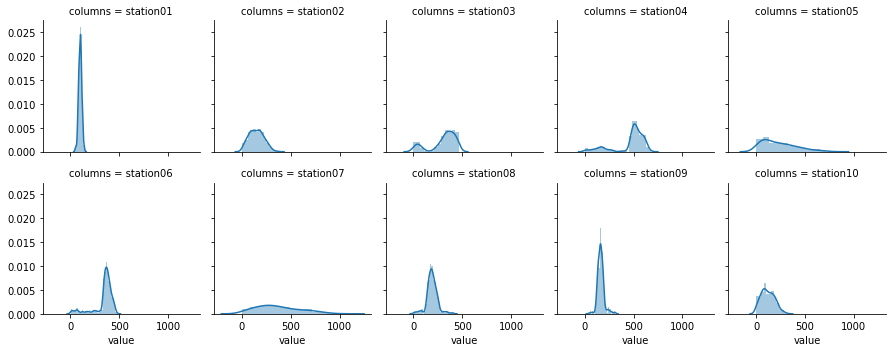

In [40]:
# Plot Odds Distributions 
g = sns.FacetGrid(df_diesel.loc[:, 'station01':'station10'].melt(var_name='columns'), 
                  col="columns", 
                  col_wrap=5, 
                  height=2.5)
g.map(sns.distplot, 'value')

Now we have one data set with all the stations and liters of diesel sold. Let's have a look to the summary stats:

In [5]:
import matplotlib.pyplot as plt

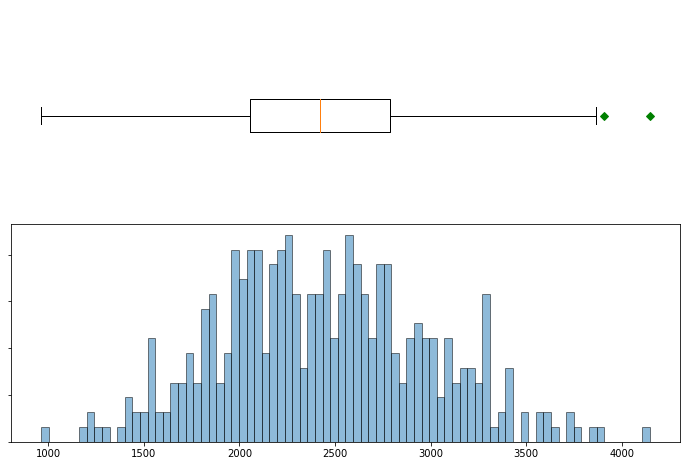

In [6]:
lis_tots = []
_ = [lis_tots.append(sum(df_diesel.iloc[i,:])) for i in range(0,len(df_diesel))]

#resizing plot and initialize subplots
plt.rcParams['figure.figsize'] = [12, 8]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
#plotting boxplot
axes[0].boxplot(lis_tots, 0, 'gD', vert=False)
axes[0].axis('off')
#plotting hist
axes[1].hist(lis_tots, 80, density=True, alpha=.5, edgecolor='black')
axes[1].set_yticklabels([])
#displaying plot
plt.subplots_adjust(hspace=0)
plt.show()

https://en.wikipedia.org/wiki/Robust_measures_of_scale

https://en.wikipedia.org/wiki/Median_absolute_deviation

In [7]:
stats.median_absolute_deviation(df_diesel, axis=None)

145.21839424648826

In [8]:
lis_mads = []
_ = [lis_mads.append(stats.median_absolute_deviation(df_diesel.iloc[i])) for i in range(0,len(df_diesel.columns))]
print(sum(lis_mads))
mad_W = sum(lis_mads)

1312.4974490024606


In [360]:
lis_mads

[82.2843,
 30.39329999999999,
 88.956,
 21.4977,
 62.277110575533506,
 102.29939999999999,
 41.5128,
 132.6927,
 83.76689999999998,
 31.29230742935966]

In [9]:
stats.median_absolute_deviation(lis_tots)

540.7532399950626

In [10]:
np.std(lis_tots)

547.484231932567

In [11]:
df_diesel.describe()

,station01,station02,station03,station04,station05,station06,station07,station08,station09,station10
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,99.441619,148.426053,306.627405,470.753109,228.681614,343.445536,367.919601,192.364653,163.556388,118.607586
std,16.234071,73.575344,133.324925,159.449276,170.454876,99.236177,220.357943,54.685664,33.325168,67.522520
min,47.663648,2.718879,1.061197,4.397033,0.581771,3.939724,0.552702,6.318098,42.259148,1.118243
25%,88.199448,91.669826,268.007558,475.219027,88.488732,343.303588,205.311173,163.624783,142.537471,66.587799
50%,100.339560,144.781562,343.590023,515.431611,194.780889,368.342027,335.993300,189.787862,161.050300,113.931699
75%,109.480054,198.612832,401.763048,569.968384,335.944578,395.864280,518.283133,219.073666,179.883799,168.240354
max,146.418439,361.245983,462.316142,680.939669,781.277506,474.517534,1039.630026,407.384492,314.097811,308.484536


We can see that all the standard deviations are bigger than the means, and because the sold liters per hour cannot be negative, this is telling us that all the distributions are skewed to the right near the 0. This is okay because we could consider them later as a "normal" distribution due to the fact we have many samples(397), but for now we can just apply some basic rules and say that **the average litre sold per hour for the company is the sum of all the means**.

In [364]:
np.sum(df_diesel.describe(),axis=1)

count    3970.000000
mean     1482.684450
std       659.029803
min       188.126121
25%       973.715306
50%      1445.431361
75%      1964.650617
max      3271.988388
dtype: float64

We can't use the sum of standard deviations but for now we can store the total average of liters sold per hour:

In [12]:
total_mean = sum(df_diesel.describe().iloc[1])
print('The toal average of liters sold per hour for the company is: approx',round(total_mean,3))

The toal average of liters sold per hour for the company is: approx 2439.824


In [13]:
import statistics
medians = []
[medians.append(statistics.median(df_diesel.iloc[:,i])) for i in range(0,len(df_diesel.columns))]
total_median = sum(medians)
print(total_median)

2468.02883237973


To calculate the sum of standard deviations we have to sum the variance of all the stations, but before we do that we have to verify that the liters sold per station are independent to each other. 

We have to analize the correlation between them, and to do this I'll create an heatmap with help of `seaborn` library. 

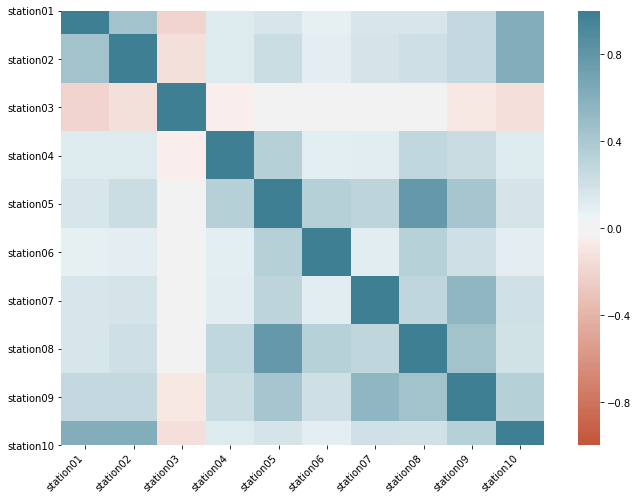

In [24]:
import seaborn as sns

corr = df_diesel.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=0,
);

There are some positive and negative correlations between stations (more the blue, more positive the correlation is, and more the negative more red is the color). So it is clear that our stations are not really independent. 

In this case, to calculate the overall variance we will need to calculate the covariance as well. I'll start by computing a covariance table in python.

In [15]:
df_diesel.cov()

,station01,station02,station03,station04,station05,station06,station07,station08,station09,station10
station01,263.545074,524.223772,-444.523665,338.332407,473.941933,131.504270,588.792041,141.623995,144.421300,668.447656
station02,524.223772,5413.331301,-1175.470345,1513.407522,2991.104721,658.813105,2949.780676,858.442549,652.872935,3098.153845
station03,-444.523665,-1175.470345,17775.535495,-910.884210,-736.048221,-437.162845,-425.449576,170.523981,-354.620739,-1240.010541
station04,338.332407,1513.407522,-910.884210,25424.071579,9200.115147,1666.724509,4053.332476,2452.626229,1302.479945,1268.846931
station05,473.941933,2991.104721,-736.048221,9200.115147,29054.864907,5861.191949,11608.932511,7224.946221,2441.208972,2103.946419
station06,131.504270,658.813105,-437.162845,1666.724509,5861.191949,9847.818797,2465.223640,1803.917999,698.507701,611.736914
station07,588.792041,2949.780676,-425.449576,4053.332476,11608.932511,2465.223640,48557.622830,3542.673580,4009.162655,2995.068146
station08,141.623995,858.442549,170.523981,2452.626229,7224.946221,1803.917999,3542.673580,2990.521902,808.232096,693.890804
station09,144.421300,652.872935,-354.620739,1302.479945,2441.208972,698.507701,4009.162655,808.232096,1110.566816,756.384329
station10,668.447656,3098.153845,-1240.010541,1268.846931,2103.946419,611.736914,2995.068146,693.890804,756.384329,4559.290660


In general, we have to sum all the variances with all the permutations without repetitions and ordered of covariance values of couples: (k-permutations)$\frac{n!}{(n-k)!}$.

$$Total\ variation\ among\ stations =\sum_iVar(St_i)+2\sum_{i<j}Cov(St_i,St_j)$$

For example:

$$=Var(A)+Var(B)+Var(C)+2Cov(A,B)+2Cov(A,C)+2Cov(B,C)$$

Using formalism of the ***matrix of covariance*** we can then apply it to all possible cases in python without other transformations of computations.

If we have a sum of *N* stations such as:

$$W =\sum_{n=1}^{N}a_nSt_n$$

we can write the variance of *W* in matrix formalism as:

$$ Var[W] = v^TM_v $$

where *v* is a vector containing all the $a_n$:

$$v = \begin{pmatrix} a_1 \\ a_2 \\ \vdots \\ a_n\end{pmatrix}$$

$Cov[St_a,St_a] = Var[St_a] $ so the covariance table we have above is the same as the matrix *M* (the matrix of covariance):

$$ 
 \begin{pmatrix}
  Var[St_1] & Cov[St_1,St_2] & Cov[St_1,St_3] & \cdots & Cov[St_1,St_n] \\
  Cov[St_2,St_1] & Var[St_2] & Cov[St_2,St_3] & \cdots & Cov[St_2,St_n] \\
  Cov[St_3,St_1] & Cov[St_3,St_2] & Var[St_3] & \cdots & Cov[St_3,St_n] \\
  \vdots  & \vdots  & \vdots & \ddots & \vdots  \\
  Cov[St_n,St_1] & Cov[St_n,St_2] &  Cov[St_n,St_3] & \cdots & Var[St_n]
 \end{pmatrix}
$$

which is a symmetric matrix, with $Cov[St_a,St_b]=Cov[St_b,St_a]$ so:

$$Var[W] = \sum_iVar(St_i)+2\sum_{i<j}Cov(St_i,St_j) = v^TM_v $$

that it can be computed by the sum of all the elements of the matrix:

In [43]:
var_W = df_diesel.cov().to_numpy().sum()
print('The total variation is:',var_W)
#sqrt to calculate the standard deviation
stdv_W = var_W**0.5
print('The standard deviation σ is:',stdv_W)
#print the overall mean
print('The mean μ is:',total_mean)
print('The median is:',total_median)

The total variation is: 300495.90084159793
The standard deviation σ is: 548.1750640457826
The mean μ is: 2439.82356510628
The median is: 2468.02883237973


In [17]:
skewness_w = 3*(total_mean -total_median)/stdv_W 
skewness_w

-0.15435908593843412

In [41]:
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import lognorm
from scipy.stats import skew

In [341]:
a, b = 0, 1500
mu, sigma = 100, 15
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)

values = dist.rvs(397)

In [347]:
dflit = pd.DataFrame(values)
dflit.to_excel("output.xlsx")

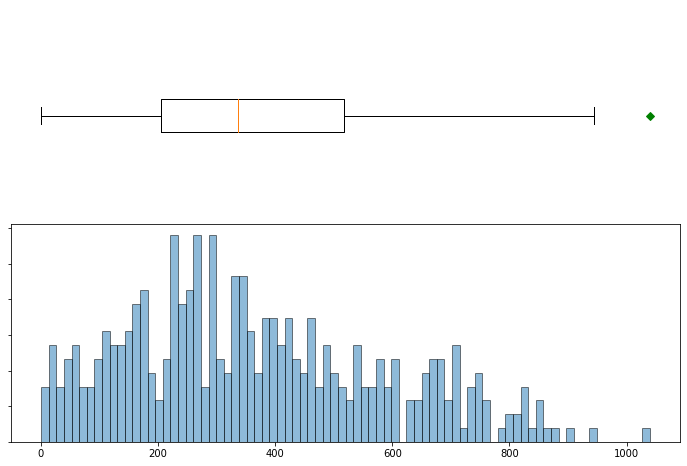

In [27]:
datz = df_diesel.station07
#resizing plot and initialize subplots
plt.rcParams['figure.figsize'] = [12, 8]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
#plotting boxplot
axes[0].boxplot(datz, 0, 'gD', vert=False)
axes[0].axis('off')
#plotting hist
axes[1].hist(datz, 80, density=True, alpha=.5, edgecolor='black')
axes[1].set_yticklabels([])
#displaying plot
plt.subplots_adjust(hspace=0)
plt.show()

In [101]:
%matplotlib inline
from ipywidgets import interactive

np.random.seed(2006)
#normal distribution 
mu, sigma = total_mean, stdv_W # mean and standard deviation
s = abs(np.random.normal(mu, sigma, 5000))


def f(liters):

    # Create Figure and Axes instances
    fig,ax = plt.subplots(1)

    #plotting with denisty curve
    count, bins, ignored = plt.hist(s, 100, density=True, 
                                alpha=.1, edgecolor='black')
    x = bins
    y = norm.pdf(x, mu, sigma)

    # define components for area calculations
    upper_bound = max(x)

    ax.plot(x,y, linewidth=2, color='r')
    ax.fill_between(x,y, where= (x>liters), color='c')
    ax.axvline(mu, color='black', alpha=1, linewidth=.5)
    ax.annotate('μ', xy=(mu+30,max(y)+0.00022), ha='left')
   
    #CDF comulative distribution function 
    plt.annotate("{:.2f}%".format(100*(
                                  norm(mu, sigma).sf(liters))), 
                 xy=(abs(liters)+300, min(y)*250), ha='center')

    ax.set_yticklabels([])
    ax.set_ylabel('frequency')
    ax.set_xlabel('liters of diesel sold per hour for the company')
    plt.show()

    
interactive_plot = interactive(f, liters=(round(min(s),0), round(max(s),0)*1.43, 25))
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=3518.0, description='liters', max=6496.49, min=543.0, step=25.0), Outp…

***

## . Wine Sales Distribution Mapping for KPI Assesment

A wine distribution company is requesting a sales distribution map to asses KPI based on specific district coverages.

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

http://www.comuni-italiani.it/03/index.html

http://www.sottomentitespoglie.it/GeneratoreAziende.aspx

http://www.comuniverso.it/index.cfm?pagina=genera%20mappa

In [1]:
import pandas as pd
import numpy as np

In [25]:
dat = pd.read_excel('wine_sales_data.xlsx',
sheet_name=['Barbera','Bonarda'],
header=0,
index_col=False,
keep_default_na=True
)
#display first rows
dat

OrderedDict([('Barbera',
                  WineType  InvoiceID          Region District                 City  QtySold
              0    Barbera        629       Lombardia  Brescia  Desenzano del Garda        6
              1    Barbera        962       Lombardia  Brescia          Montichiari       30
              2    Barbera       2457       Lombardia  Mantova              Suzzara       13
              3    Barbera       3388       Lombardia    Pavia              Voghera       53
              4    Barbera        243  Emilia-Romagna  Bologna                Imola       24
              ..       ...        ...             ...      ...                  ...      ...
              790  Barbera     125370          Veneto   Verona          Vestenanova        6
              791  Barbera      79375          Veneto  Vicenza            Agugliaro        7
              792  Barbera      74880          Veneto  Vicenza            Albettone       13
              793  Barbera      64242        

From the excel file we have collected data for Barbera and Bonarda wine, the features are:

- ***WineType***: *Barbera* or *Bonarda*
- ***InvoiceID***: The ID of the invoice of the sales operation
- ***Region***: The region of Italy where the bottles was sold
- ***District***: The district of the region where the bottles was sold
- ***City***: The city where the bottles was sold
- ***QtySold***: Then we have the quantity of the bottles of wine sold for each InvoiceID

We can access the dataframes of each type of wine like this:

In [26]:
wines = list(dat.items())
#selecting the first (Barbera) [0] the first dict, and [1] the first table
wines[0][1]

,WineType,InvoiceID,Region,District,City,QtySold
0,Barbera,629,Lombardia,Brescia,Desenzano del Garda,6
1,Barbera,962,Lombardia,Brescia,Montichiari,30
2,Barbera,2457,Lombardia,Mantova,Suzzara,13
3,Barbera,3388,Lombardia,Pavia,Voghera,53
4,Barbera,243,Emilia-Romagna,Bologna,Imola,24
...,...,...,...,...,...,...
790,Barbera,125370,Veneto,Verona,Vestenanova,6
791,Barbera,79375,Veneto,Vicenza,Agugliaro,7
792,Barbera,74880,Veneto,Vicenza,Albettone,13
793,Barbera,64242,Veneto,Vicenza,Alonte,3


In [27]:
#descriptives
dfbarb = wines[0][1]
dfbona = wines[1][1]
print(dfbarb.describe())
print('Total n° of bottle sold for Barbera wine:',sum(dfbarb.QtySold),'\n')
print(dfbona.describe())
print('Total n° of bottle sold for Bonarda wine:',sum(dfbona.QtySold))

           InvoiceID     QtySold
count     795.000000  795.000000
mean    47352.113208   11.870440
std     48557.310413   12.542003
min       140.000000    1.000000
25%     10651.500000    6.000000
50%     31992.000000   10.000000
75%     67580.000000   14.000000
max    276332.000000  184.000000
Total n° of bottle sold for Barbera wine: 9437 

           InvoiceID     QtySold
count     611.000000  611.000000
mean    51164.878887   13.828151
std     57179.465479   18.276158
min       106.000000    1.000000
25%     10807.500000    6.000000
50%     29700.000000   10.000000
75%     69934.500000   13.000000
max    297616.000000  179.000000
Total n° of bottle sold for Bonarda wine: 8449


From summary statistics we can see that the two types of wine have similar selling stats.

Now we need to process the data. To graphically represent distributions of bottle sold, instead of representing circles by quantity sold and plotting them on the map, we will use a technique slightly more sophisticated applied to species distribution of recorded observations. In the same way we can view the density map of distribution sales, like observations of species in the territory, and our species will be the type of wine.

To do that first we need to expand our data, and duplicate/replicate the quantities for each sale. This because we need number of observations and not quntity of sales. The only data we need in this new dataset is the city and region:

In [28]:
locdfbarb = np.repeat((dfbarb.Region+', '+dfbarb.City), dfbarb.QtySold)
locdfbona = np.repeat((dfbona.Region+', '+dfbona.City), dfbona.QtySold)
print(locdfbarb)
print(locdfbona)

0      Lombardia, Desenzano del Garda
0      Lombardia, Desenzano del Garda
0      Lombardia, Desenzano del Garda
0      Lombardia, Desenzano del Garda
0      Lombardia, Desenzano del Garda
                    ...              
794          Veneto, Asigliano Veneto
794          Veneto, Asigliano Veneto
794          Veneto, Asigliano Veneto
794          Veneto, Asigliano Veneto
794          Veneto, Asigliano Veneto
Length: 9437, dtype: object
0         Lombardia, Adrara San Martino
0         Lombardia, Adrara San Martino
0         Lombardia, Adrara San Martino
0         Lombardia, Adrara San Martino
0         Lombardia, Adrara San Martino
                     ...               
610    Lombardia, San Martino in Strada
610    Lombardia, San Martino in Strada
610    Lombardia, San Martino in Strada
610    Lombardia, San Martino in Strada
610    Lombardia, San Martino in Strada
Length: 8449, dtype: object


We can see that now we have the number of elements exactly as the number of bottles sold for each type of wine.

Now we need to get the coordinates for the locations we have, this process can be done with `geopy.geocoders` library:

In [29]:
from geopy.geocoders import Nominatim
import time

The code to collect all the coordinates is simple but can take several minutes to run (approx 5min), just be patient.

In [31]:
#initializing geolocator
geolocator = Nominatim(user_agent="nev_SLM_app")

#np.array assignment
latbarb = np.array([])
lonbarb = np.array([])
latbona = np.array([])
lonbona = np.array([])

#spliting lists of locations into smaller chunks
#to avoid geolocator overloads and disconnections errors
f = lambda x,y: [ x[i:i+y] for i in range(0,len(x),y)]
lsbarb = f(range(0, len(locdfbarb)), 1000)
lsbona = f(range(0, len(locdfbona)), 1000)

#elaborating coordinates for Barbera wine
#iterating over every chunk of data
print('...please wait: coordinates elaboration for Barbera sales locations in progress!')
for x in lsbarb:
    time.sleep(1)
    c = 0
    for i in locdfbarb[min(x):max(x)+1]:
        if (locdfbarb[c-1:c].any() == locdfbarb[c:c+1].any()):
            if (len(latbarb)==0):
                pass
            else:
                latbarb = np.append(latbarb, latbarb[len(latbarb)-1])
                lonbarb = np.append(lonbarb, lonbarb[len(lonbarb)-1]) 
        else:
            try:
                location = geolocator.geocode(i)
                latbarb = np.append(latbarb, location.latitude)
                lonbarb = np.append(lonbarb, location.longitude)
            except:
                try:
                    time.sleep(1)
                    location = geolocator.geocode(i)
                    latbarb = np.append(latbarb, location.latitude)
                    lonbarb = np.append(lonbarb, location.longitude)
                except:
                    print('Error occured! Check later for missing Barbera coordinates data(assigned -1)')
                    latbarb = np.append(latbarb, -1)
                    lonbarb = np.append(lonbarb, -1)  
        c += 1
print('Barbera wine locations coordinates DONE!')

#elaborating coordinates for Bonarda wine
#iterating over every chunk of data
print('...please wait: coordinates elaboration for Bonarda sales locations in progress!')
for x in lsbona:
    time.sleep(1)
    c = 0
    for i in locdfbona[min(x):max(x)+1]:
        if (locdfbona[c-1:c].any() == locdfbona[c:c+1].any()):
            if (len(latbona)==0):
                pass
            else:
                latbona = np.append(latbona, latbona[len(latbona)-1])
                lonbona = np.append(lonbona, lonbona[len(lonbona)-1]) 
        else:
            try:
                location = geolocator.geocode(i)
                latbona = np.append(latbona, location.latitude)
                lonbona = np.append(lonbona, location.longitude)
            except:
                try:
                    time.sleep(1)
                    location = geolocator.geocode(i)
                    latbona = np.append(latbona, location.latitude)
                    lonbona = np.append(lonbona, location.longitude)
                except:
                    print('Error occured! Check later for missing Bonarda coordinates data(assigned -1)')
                    latbona = np.append(latbona, -1)
                    lonbona = np.append(lonbona, -1)                
        c += 1
print('Bonarda wine locations coordinates DONE!')

...please wait: coordinates elaboration for Barbera sales locations in progress!
Barbera wine locations coordinates DONE!
...please wait: coordinates elaboration for Bonarda sales locations in progress!
Bonarda wine locations coordinates DONE!


We have all the data locations coordinates, now let's check if there are errors:

In [32]:
#checking for errors
#and printing results
print('Result check:')
time.sleep(0.330)
if (len(latbarb)==len(lonbarb)):
    if (len(locdfbarb)==len(lonbarb)):
        print('GOOD: The number of elements for Barbera is correct!')
    else:
        print('ERROR: The number of elements for Barbera are not the same.')
else:
    print('ERROR: The number of lat and lon coordinates for Barbera are not the same.')
time.sleep(0.330)
if (len(latbona)==len(lonbona)):
    if (len(locdfbona)==len(lonbona)):
        print('GOOD: The number of elements for Bonarda is correct!')
    else:
        print('ERROR: The number of elements for Bonarda are not the same.')
else:
    print('ERROR: The number of lat and lon coordinates for Bonarda are not the same.')
time.sleep(0.330)
print('Missing value check:')
time.sleep(0.330)
barbmissing = sum(1 for i in latbarb if i == -1)
print('Number of missing values for Barbera coordinates =',barbmissing)
time.sleep(0.330)
bonamissing = sum(1 for i in latbona if i == -1)
print('Number of missing values for Bonarda coordinates =',bonamissing)
time.sleep(0.330)
if (barbmissing >0 and barbmissing/len(locdfbarb) < 0.05):
    print('N° of missing < 5%: Removing missing Barbera data...')
    latbarb = list(filter(lambda x: x == [-1], latbona))
    lonbarb = list(filter(lambda x: x == [-1], latbona))
else:
    if (barbmissing > 0):
        print('There are too many missing coordinates! Restart again the code, or check list of locations.')
time.sleep(0.330)
if (bonamissing >0 and bonamissing/len(locdfbona) < 0.05):
    print('N° of missing < 5%: Removing missing Bonarda data...')
    latbona = list(filter(lambda x: x == [-1], latbona))
    lonbona = list(filter(lambda x: x == [-1], latbona))
else:
    if (bonamissing > 0):
        print('There are too many missing coordinates! Restart again the code, or check list of locations.')

Result check:
GOOD: The number of elements for Barbera is correct!
GOOD: The number of elements for Bonarda is correct!
Missing value check:
Number of missing values for Barbera coordinates = 0
Number of missing values for Bonarda coordinates = 0


So we've got all the coordinates for all locations without errors and missing data.

Now we can save the data into a csv file:

In [52]:
#collecting Barbera data
Type = 'Barbera'
data_barbera = list(zip(locdfbarb, latbarb, lonbarb))
df_barbera = pd.DataFrame(data_barbera, columns = ['Location', 'Latitude', 'Longitude']) 
df_barbera['Type'] = Type
#collecting Bonarda data
Type = 'Bonarda'
data_bonarda = list(zip(locdfbona, latbona, lonbona))
df_bonarda = pd.DataFrame(data_bonarda, columns = ['Location', 'Latitude', 'Longitude']) 
df_bonarda['Type'] = Type
#appending all data together
df_all = df_barbera.append(df_bonarda, ignore_index=True)
#saving into csv file
df_all.to_csv ('wine_sales_coordinates.csv', index = None, header=True)
print(df_all)

                               Location   Latitude  Longitude     Type
0        Lombardia, Desenzano del Garda  45.469485  10.538947  Barbera
1        Lombardia, Desenzano del Garda  45.469485  10.538947  Barbera
2        Lombardia, Desenzano del Garda  45.469485  10.538947  Barbera
3        Lombardia, Desenzano del Garda  45.469485  10.538947  Barbera
4        Lombardia, Desenzano del Garda  45.469485  10.538947  Barbera
...                                 ...        ...        ...      ...
17881  Lombardia, San Martino in Strada  45.360000   9.106028  Bonarda
17882  Lombardia, San Martino in Strada  45.360000   9.106028  Bonarda
17883  Lombardia, San Martino in Strada  45.360000   9.106028  Bonarda
17884  Lombardia, San Martino in Strada  45.360000   9.106028  Bonarda
17885  Lombardia, San Martino in Strada  45.360000   9.106028  Bonarda

[17886 rows x 4 columns]


In [2]:
df_all = pd.read_csv('wine_sales_coordinates.csv')

In [3]:
#create a grid from data
xgrid = np.sort(np.array(list(set(df_all.Longitude))))
ygrid = np.sort(np.array(list(set(df_all.Latitude))))
#convert type into dummy variable
types = np.array([1 if i=="Barbera" else 0 for i in df_all.Type], dtype='int')
#lat lon array from df
latlon = np.vstack([df_all.Latitude,
                    df_all.Longitude]).T

latlon

In [54]:
print(xgrid.mean())
print(ygrid.mean())

9.748820669972083
45.4366674414794


Italy districts shapefile from :https://www4.istat.it/it/archivio/209722

Country shapefiles from:https://www.diva-gis.org/gdata

In [4]:
import geopandas as gp

In [30]:
s = gp.read_file(r'ProvCM01012018_g\ProvCM01012018_g_WGS84.shp')

#checking type of projection
s.crs

{'init': 'epsg:32632'}

So we have WGS84 (EPSG:32632) we need to re-project to EPSG:4326 in order to be used on our plot below.

In [32]:
#make a copy of shapefile
s_proj = s.copy()
#using os to link the 'PROJ_LIB' to environment
import os
os.environ['PROJ_LIB'] = '/Users/Pc/Anaconda3/pkgs/proj4-5.1.0-hfa6e2cd_1/Library/share'
#re.project to epsg:4326 and print head of conversion
s_proj['geometry'] = s_proj['geometry'].to_crs(epsg=4326)
s_proj['geometry'].head()

0    POLYGON ((7.85904 45.59758, 7.86228 45.59699, ...
1    POLYGON ((8.20447 45.93567, 8.21365 45.92490, ...
2    POLYGON ((8.49688 45.83934, 8.49996 45.83402, ...
3    MULTIPOLYGON (((7.99090 44.82381, 7.99348 44.8...
4    POLYGON ((8.04681 45.12815, 8.04572 45.12300, ...
Name: geometry, dtype: geometry

In [33]:
#write the new shapefile with a different name
s_proj.to_file(r'ProvCM01012018_g\ProvCM01012018_EPSG4326.shp')

Now that the shapefile with our italian districts are reprojected as we want, we can start `basemap` and start to plot our coordinates: 

In [4]:
#importing library
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

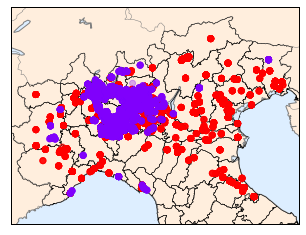

In [57]:
#plot coastlines and shapefile with basemap
zoom = 0.5
m = Basemap(projection='tmerc', lat_0 = 45.5, lon_0 = 10, resolution='i',
            llcrnrlat=ygrid.min()-zoom, urcrnrlat=ygrid.max()+zoom,
            llcrnrlon=xgrid.min()-zoom, urcrnrlon=xgrid.max()+zoom)
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)
m.readshapefile(r'ProvCM01012018_g\ProvCM01012018_EPSG4326','ProvCM01012018_EPSG4326')

#resizing plot
plt.rcParams['figure.figsize'] = [16, 4]

#plot selling locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3, alpha=0.3,
          c=types, cmap='rainbow', latlon=True);

As we can see the plot is okay, but it is not usefull even adjusting alpha of the scatter plot we cannot see how the sales are covering or not the districts. We need to use the Kernel Density Estimation method to plot a density map over the territory and make it easy for the company to evaluate KPIs.

In [5]:
from sklearn.neighbors import KernelDensity

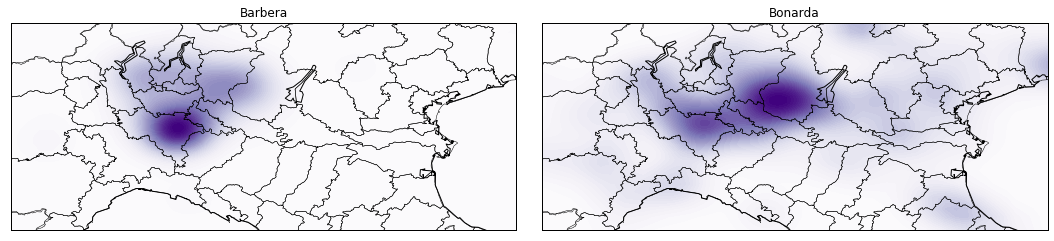

In [175]:
#Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy)

#Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Barbera', 'Bonarda']
cmaps = ['Purples', 'Purples']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    #plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='i', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    m.readshapefile(r'ProvCM01012018_g\ProvCM01012018_EPSG4326','ProvCM01012018_EPSG4326')
    
    #construct a spherical kernel density estimate of the distribution with 'haversine' metric
    kde = KernelDensity(kernel='gaussian', bandwidth=0.003, metric='haversine')
    kde.fit(np.radians(latlon[types == i]))

    #evaluate Z
    Z = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    #plot contours of the density
    levels = np.linspace(0, Z.max(), 50)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

In [150]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
import shapefile
import matplotlib.font_manager as fm

In [157]:
kpi_barb = ['Milano','Monza e della Brianza','Pavia','Como','Biella','Verbano-Cusio-Ossola',
             'Varese','Lecco','Bergamo','Brescia','Cremona','Lodi',
             'Novara','Vercelli','Asti','Alessandria','Piacenza','Genova']

kpi_bona = ['Milano','Monza e della Brianza','Pavia','Cremona', 'Vicenza',
             'Lodi','Mantova','Brescia','Verona','Bergamo','Padova', 'Piacenza',
             'Ferrara','Rovigo','Venezia','Treviso','Ravenna']

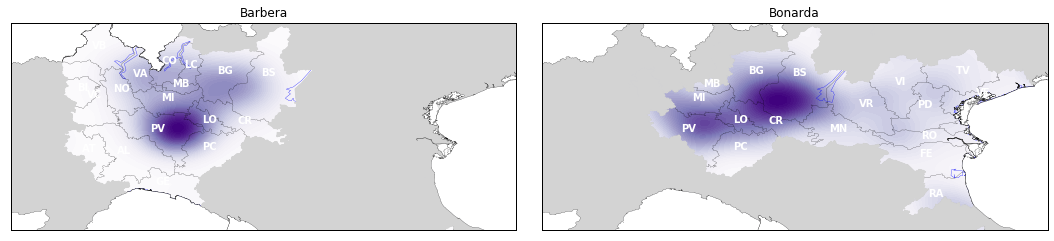

In [176]:
#Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy)

#resizing plot
plt.rcParams['figure.figsize'] = [16, 4]

#Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
wine_names = ['Barbera', 'Bonarda']
cmaps = ['Purples', 'Purples']

#initializing lists for all types
ex_barb, ep_barb, ex_bona, ep_bona = ([] for i in range(4))
sig_check_barb, sig_check_bona, sig_barb_m, sig_bona_m = ([] for i in range(4))
patches = [patches_barb,patches_bona]
patches_c = [p_barb,p_bona]
siglas = [sig_barb_m,sig_bona_m]
sigg = [sig_barb,sig_bona]
sigg_s = [sig_check_barb,sig_check_bona]
grids_ex = [ex_barb,ex_bona]
grids_ep = [ep_barb,ep_bona]
kpis = [kpi_barb,kpi_bona]
#initializing font variable for plotting district initials
font = fm.FontProperties(weight='bold')

for i, axi in enumerate(ax):
    axi.set_title(wine_names[i])
    
    #basemap intialization, coastlines and national limits
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='i', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines(color='blue', linewidth=0.3)
    m.drawcountries()
    m.readshapefile(r'ProvCM01012018_g\ProvCM01012018_EPSG4326','ProvCM01012018_EPSG4326', drawbounds = False)
    m.readshapefile(r'medi_ita\adri','adri')
    m.readshapefile(r'medi_ita\west_basin','west_basin')
    m.readshapefile(r'FRA_adm\FRA_adm0','FRA_adm0')
    m.readshapefile(r'CHE_adm\CHE_adm0','CHE_adm0')
    
    #construct a spherical kernel density estimate of the distribution with 'haversine' metric
    kde = KernelDensity(kernel='gaussian', bandwidth=0.003, metric='haversine')
    kde.fit(np.radians(latlon[types == i]))

    #evaluate Z
    Z = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    #plot contours of the density
    levels = np.linspace(0, Z.max(), 50)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])
    
    #initializing shapes from shapefiles
    shapes = [m.adri,m.west_basin,m.CHE_adm0,m.FRA_adm0]
    patches_it = [Polygon(np.array(shape), True) for shapez in shapes for shape in shapez]
    
    #initializing other districts shapes for masking  
    patches[i] = [Polygon(np.array(shape), True) 
                    for info, shape in 
                    zip(m.ProvCM01012018_EPSG4326_info, m.ProvCM01012018_EPSG4326) 
                    if info['DEN_PCM'] not in kpis[i]]            
    
    #initializing districts shapes of interest
    patches_c[i] = [Polygon(np.array(shape), True) 
                    for info, shape in 
                    zip(m.ProvCM01012018_EPSG4326_info, m.ProvCM01012018_EPSG4326) 
                    if info['DEN_PCM'] in kpis[i]]           
    
    #initializing districts initials
    sigg[i] = list(set([info['SIGLA']
                    for info in 
                    m.ProvCM01012018_EPSG4326_info 
                    if info['DEN_PCM'] in kpis[i]]))
    
    #collecting coordinates and initials district names to plot
    c = 0
    for info, shape in zip(m.ProvCM01012018_EPSG4326_info, m.ProvCM01012018_EPSG4326):
        if info['SIGLA'] in sigg[i]:
            sigg_s[i].append(info['SIGLA'])
            c += 1
            if sigg_s[i].count(sigg_s[i][c-1]) < 2:
                # center of polygon 
                x, y = np.array(shape).mean(axis=0)
                siglas[i].append(info['SIGLA'])
                grids_ex[i].append(x)
                grids_ep[i].append(y)
    
    #district borders of interest plot            
    axi.add_collection(PatchCollection(patches_c[i], color= '', edgecolor='k', linewidths=0.1, zorder=2, alpha=1))    
    #districts masking plot
    axi.add_collection(PatchCollection(patches[i], color='lightgrey', zorder=2, alpha=1))    
    #country masking plot
    axi.add_collection(PatchCollection(patches_it, color='white', edgecolor='k', linewidths=0.2, zorder=2, alpha=1))
    #plot district initials 
    [
     axi.text(ex, ep, siglas[i][ind], 
              color="white", fontproperties=font, ha="center")
     for ind in range(0,len(siglas[i]))
     for ex,ep in zip(np.nditer(grids_ex[i][ind]),np.nditer(grids_ep[i][ind])) 
     ]     
     

In [163]:
das=[1,2,3,4,5,6,7,8,9]
bbb=[]
ccc=[]
aaa=[bbb,ccc]
for i in das:
    aaa[0].append(i)

In [170]:
sigg_s[1][1]

'MI'

In [ ]:
c = 0
for info, shape in zip(m.ProvCM01012018_EPSG4326_info, m.ProvCM01012018_EPSG4326):
    if info['SIGLA'] in sig_barb:
        sig_check_barb.append(info['SIGLA'])
        c += 1
        if sig_check_barb.count(sig_check_barb[c-1]) < 2:
            # center of polygon 
            x, y = np.array(shape).mean(axis=0)
            sig_barb_m.append(info['SIGLA'])
            ex_barb.append(x)
            ep_barb.append(y)
c = 0            
for info, shape in zip(m.ProvCM01012018_EPSG4326_info, m.ProvCM01012018_EPSG4326):
    if info['SIGLA'] in sig_bona:
        sig_check_bona.append(info['SIGLA'])
        c += 1
        if sig_check_bona.count(sig_check_bona[c-1]) < 2:
            # center of polygon 
            x, y = np.array(shape).mean(axis=0)
            sig_bona_m.append(info['SIGLA'])
            ex_bona.append(x)
            ep_bona.append(y)